# Jumpstart into Multi-User MIMO Neural Receiver for 5G NR PUSCH

This notebook introduces the training and evaluation pipeline of the neural receiver (NRX).
The idea of a neural receiver is to train a single neural network (NN) to jointly perform channel estimation, equalization, and demapping. 
The detailed architecture is described in [[1]](#references) and an overview is given in the [NRX Architecture Notebook](nrx_architecture.ipynb).
After training, the TensorFlow model can be directly exported to [ONNX](https://onnx.ai/) and [NVIDIA TensorRT](https://developer.nvidia.com/tensorrt) can be used for real-time inference.

Please note that this framework relies on the [Sionna link-level simulator](https://nvlabs.github.io/sionna/). We recommend the [Sionna tutorials](https://nvlabs.github.io/sionna/examples/Sionna_tutorial_part1.html) to get familiar with basic concepts and its terminology.
In particular, the [5G NR PUSCH tutorial](https://nvlabs.github.io/sionna/examples/5G_NR_PUSCH.html) is recommended to understand the DMRS and slot configuration.

A basic introduction to neural receivers can be found in the [Sionna neural receiver notebook](https://nvlabs.github.io/sionna/examples/Neural_Receiver.html).


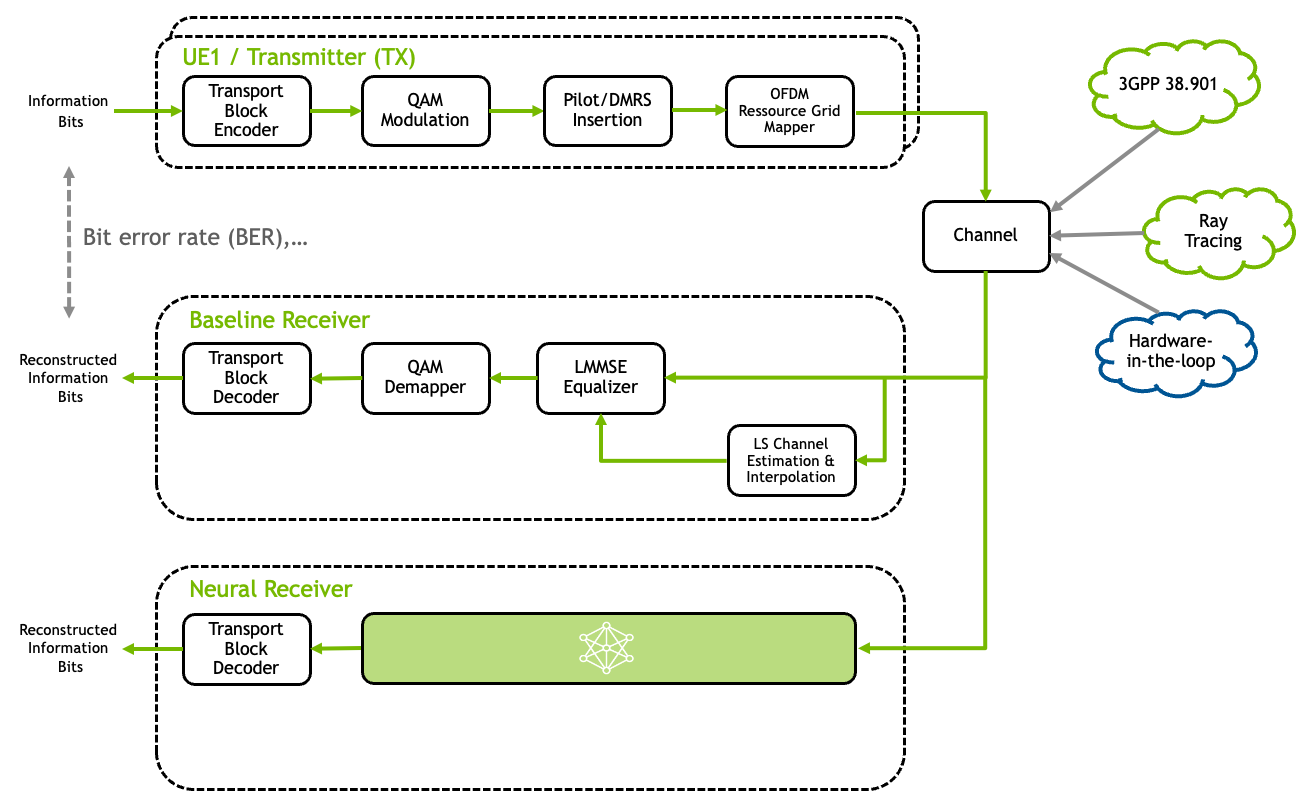

## Table of Contents
* [Background Information](#Background-Information)
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Define Config File](#Define-Config-File)
* [Training the Neural Receiver](#Training-the-Neural-Receiver)
* [Evaluating the BLER Performance](#Evaluating-the-BLER-Performance)
* [Plot the BLER Results](#Plot-the-BLER-Results)
* [Advanced Topics](#Advanced-Topics)

    * [Real-time Inference](#Real-time-Inference)
    
    * [Hardware Impairments](#Hardware-Impairments)

    * [Site-specific Training](#Site-specific-Training)

    * [End-to-end Learning and Pilotless Communications](#End-to-end-Learning-and-Pilotless-Communications)

* [References](#References)

## Background Information

The workflow consists of the following steps:
1. `Define` a config-file: this includes the entire system configuration including detailed NRX architecture and training/evaluation parameters
2. `Train` the NRX and track training performance in Tensorboard
3. `Evaluate` the BLER performance of the receiver and compare against baselines
4. `Export` the model to ONNX fileformat and run as TensorRT-engine for real-time performance analysis

The proposed neural receiver focuses on the 5G NR PUSCH channel (uplink) and supports the following features:
- Variable number of PRBs (up to 273 PRBs; equals 100MHz bandwidth with 30kHz subcarrier spacing)
- Different number of active users and DMRS ports
- Variable 5G NR DRMS configurations (might require re-training or finetuning)
- Different number of receive antennas (requires re-training)
- Re-configurable MCS selection without re-training (see [variable MCS](variable_mcs_nrx.ipynb))

Furthermore, this framework also support end-to-end learning for pilotless communications [[2]](#references). Please see notebook on [end-to-end pilotless communications](e2e_pilotless_communications.ipynb) for further details.

## GPU Configuration and Imports

In [1]:
# import relevant packages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress tf warnings

gpu_num = 0 # Number of the GPU to be used
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

import sys
sys.path.append('../') # to access all relevant repo files

%load_ext autoreload
%autoreload 2

from utils import E2E_Model, Parameters, load_weights, plot_results
import numpy as np

Number of GPUs available : 2
Only GPU number 0 used.


## Define Config File

Each config file must be in the `config` folder.
New config files can be generated for customized experiments.

A config file consists of the following sections:

- `global`: the `label` is used as nametag for all relevant files related to this specific experiment (weights, results, logs,...).
- `system`: 5G system parameters; see [Sionna PUSCH API documentation](https://nvlabs.github.io/sionna/api/nr.html#pusch) for detailed explanation of each entry.
- `baseline`: parameters of the baseline receiver implementation
- `neural_receiver`: definition of the NRX architecture
- `training`: training parameters including channel definitions for training
- `evaluation`: parameters used for evaluation of the system

In [2]:
config_name = "nrx_rt.cfg" # this config defines the entire training and evaluation pipeline

We can now load the system parameters of the given config name.

If we set `training=True` the training parameters will be loaded. Otherwise, the end-to-end system model will be initialized for the evaluation parameters.

The `system` parameter defines which receiver is initialized (mostly for comparison with a baseline). The following options are available:
- `"nrx"` : Neural receiver
- `"baseline_lmmse_kbest"` : Sionna baseline with LMMSE estimation and K-Best detection
- `"baseline_perf_csi_kbest"` : Sionna baseline with perfect CSI and K-Best detection
- `"baseline_lmmse_lmmse"` : Sionna baseline with LMMSE estimation and LMMSE equalization
- `"baseline_lsnn_lmmse"` : Sionna baseline with LS estimation/nn interpolation and LMMSE equalization

In [3]:
sys_parameters = Parameters(config_name,
                            training=True,
                            system='nrx')

Evaluating the first 2 port sets


The entry `label` in the config file sets the nametag of all relevant files
such as weights, logs, results, or datasets.
For example, after training, the weights can be found in the folder "weights/nrx_demo_weights"

In [4]:
print("Label used in this config: ", sys_parameters.label)

Label used in this config:  nrx_rt


We can now initialize an end-to-end model for the given system parameters. The training flag indicates if the loss function or the bit reconstructions are returned. Further, the model can directly return the status of the transport block (TB) CRC.

In [5]:
model = E2E_Model(sys_parameters, training=False, return_tb_status=False)

The model contains many objects such as the transmitter for the given PUSCH config. For example, we can visualize the slot configuration.

In [6]:
# prints the current PUSCH configuration (list of transmitters, one transmitter for each supported MCS)
model._transmitters[0].show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 2.8645833333333334e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 1
n_cell_id : 1
n_size_grid : 4
n_start_grid : 0
num_slots_per_frame : 20
num_slots_per_subframe : 2
num_symbols_per_slot : 14
slot_number : 0
sub_frame_duration : 0.001
subcarrier_spacing : 30
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08

PUSCH Configuration
dmrs_grid : shape (1, 48, 14)
dmrs_grid_precoded : shape (2, 48, 14)
dmrs_mask : shape (48, 14)
dmrs_symbol_indices : [2, 11]
frequency_hopping : neither
l : [2, 11]
l_0 : 2
l_bar : [2, 11]
l_d : 14
l_prime : [0]
l_ref : 0
mapping_type : A
n : shape (12,)
n_rnti : 1
n_size_bwp : None
n_start_bwp : 0
num_antenna_ports : 2
num_coded_bits : 2304
num_layers : 1
num_ov : 0
num_res_per_prb : 144
num_resource_blocks : 4
num_subcarriers : 48
precoding : codebook
precoding_matrix : [[0.70710678+0.j]
 [0.70710678+0.j]]
symbol_allocation : [0, 14]
tb_size : 1256
tpmi : 2
transform_pre

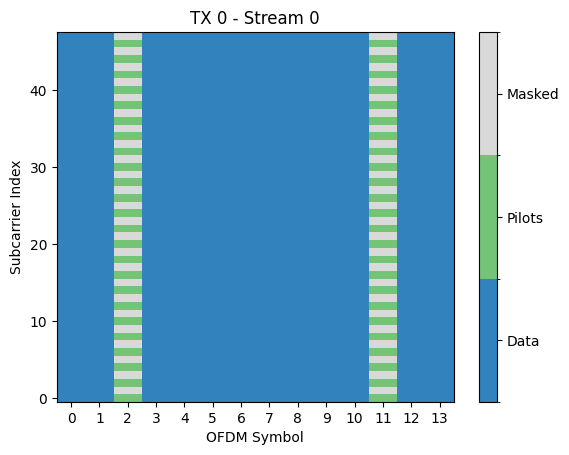

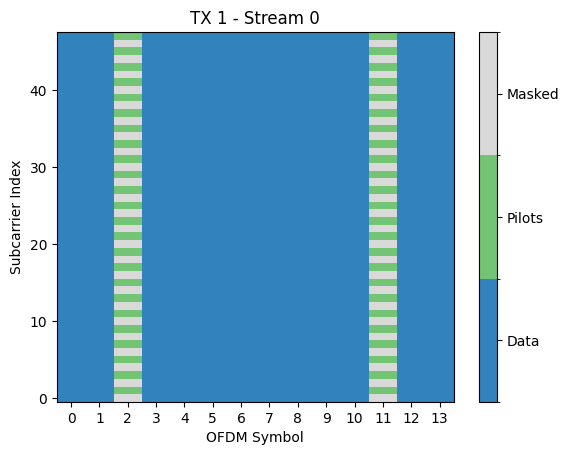

In [7]:
model._transmitters[0].pilot_pattern.show();

The model itself has two inputs:
- `batch_size`: how many random slots are transmitted
- `ebno_db`: rate-adjusted SNR in dB for which the channel is simulated

It returns the batch of transmitted payload bits `b` and its estimate at the output of the receiver `b_hat` after transmission over the channel.

In [8]:
batch_size = 10
ebno_db =5.

# In inference mode (training=False), the model returns the
# transmitted payload bits per TB (ground truth) b
# and its reconstructed estimates at the receiver output b_hat
b, b_hat = model(batch_size, ebno_db)

print("Shape b: ", b.shape)
print("Shape b_hat: ", b_hat.shape)

# The shape is [batch_size, num_tx, num_bits_per_tb]

Shape b:  (10, 2, 1256)
Shape b_hat:  (10, 2, 1256)


If weights already exists (i.e., training was already executed), we can load the weights. Otherwise, random weight initialization is used

In [9]:
model(1,1.); # dummy run to initialize the graph (required once before loading weights)

# and load the actual weights from file
filename = f'../weights/{sys_parameters.label}_weights'
load_weights(model, filename)

# use Keras default functions to summarize the model
model.summary()

Model: "e2e__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source (BinarySourc  multiple                  0         
 e)                                                              
                                                                 
 pusch_transmitter (PUSCHTr  multiple                  0         
 ansmitter)                                                      
                                                                 
 ofdm_channel (OFDMChannel)  multiple                  0         
                                                                 
 neural_pusch_receiver (Neu  multiple                  142922    
 ralPUSCHReceiver)                                               
                                                                 
Total params: 142922 (558.29 KB)
Trainable params: 142922 (558.29 KB)
Non-trainable params: 0 (0.00 Byte)
________________

The NRX object can now also be directly accessed.

In [10]:
model._receiver?

Signature:      model._receiver(*args, **kwargs)
Type:           NeuralPUSCHReceiver
String form:    <utils.neural_rx.NeuralPUSCHReceiver object at 0x7aa98c43b1f0>
File:           ~/projects/neural_rx/utils/neural_rx.py
Docstring:     
Neural PUSCH Receiver extending the CGNNOFDM Layer with 5G NR capabilities.

This layer wraps the CGNNOFDM Layer such that it is 5G NR compatible.
It includes all required steps for Transportblock (TB)/FEC decoding
including scrambling and interleaving.

Remark: for training, the labels are re-encoded with the TB-Encoder and
thus the payload (transport block) information bits must be provided.
In most practical use-cases this simplifies the data acquisition.

Parameters
----------
sys_parameters : Parameters
    The system parameters.

training : boolean
    Set to `True` if instantiated for training. Set to `False` otherwise.

Input
------
(y, active_tx, [bits, h, mcs_ue_mask]) :
    Tuple: last two inputs are only for training mode

y : [batch_size, nu

## Training the Neural Receiver

Training the neural receiver can be done by simply running the `scripts/train_neural_rx.py` script.

It has the following arguments:
- `config_name`: defines which receiver configuration is trained
- `gpu`: which GPU to use if multiple GPUs are available in the system

In [ ]:
# As training takes several hours/days, we recommend to run this command in the terminal outside of a jupyter notebook.
os.system("python ../scripts/train_neural_rx.py -config_name nrx_rt.cfg -gpu 0")

Training results are logged in the `logs/` folder and can be directly accessed via TensorBoard.

Remark: during training, random number of active users and SNR values are sampled. Thus, the loss function has a high fluctuation.
One possible solution is to implement an additional validation loss for a fixed number of active UEs. However, this is not done in this training loop and the loss must be averaged over multiple iterations (*smoothing*).

The training schedule itself is defined as Python dictionary `training_schedule`. Each entry in the dictionary is a list and the training loops over the list entries, i.e, `num_iter[i]` SGD iterations are applied for the i-*th* set of parameters. This allows to refine several training parameters during training, e.g., narrow the SNR range towards the end or different learning rates.

## Evaluating the BLER Performance

Similar to the training, the script `scripts/evaluate.py` allows to automatically evaluate the performance of the trained neural receiver and several baseline implementations.

The evaluation script has the following parameters:
- `config_name`: defines which receiver configuration is trained
- `gpu`: which GPU to use if multiple GPUs are available in the system
- `num_tx_eval`: evaluate the system for a fixed number of receiver (must be smaller or equal to the max number of available users). Remark: during training the number of users is randomized
- `eval_nn_only`: evaluate the NRX only and ignore other baselines. IF baselines have been already simulated before, only the NRX results will be updated.
- `num_target_block_errors`: how many block errors per SNR point are simulated (allows early stopping)
- `max_mc_iter`: maximum number of Monte Carlo trials per SNR point
- `target_bler`: stop BLER simulation after reaching this BLER value
- `num_cov_samples`: number of samples used for covariance sampling (only required for LMMSE-based receivers)

Remark: multi-gpu evaluation is supported, but requires to modify the `distribute` parameter in `scripts/evaluate.py`


Please note that the neural receiver is typically trained for a smaller number of PRBs. However, for the evaluation an arbitrary number can be set without any need for re-training.

In [ ]:
# Running the evaluation might take several hours (in particular the K-best
# based algorithms consume a lot of simulation time). Consider running this in
# an external terminal.
os.chdir("../scripts/")
os.system("python evaluate.py -config_name nrx_rt.cfg -gpu 0 -num_tx_eval 1")

## Plot the BLER Results

After evaluation, the results can be directly plotted for comparison.

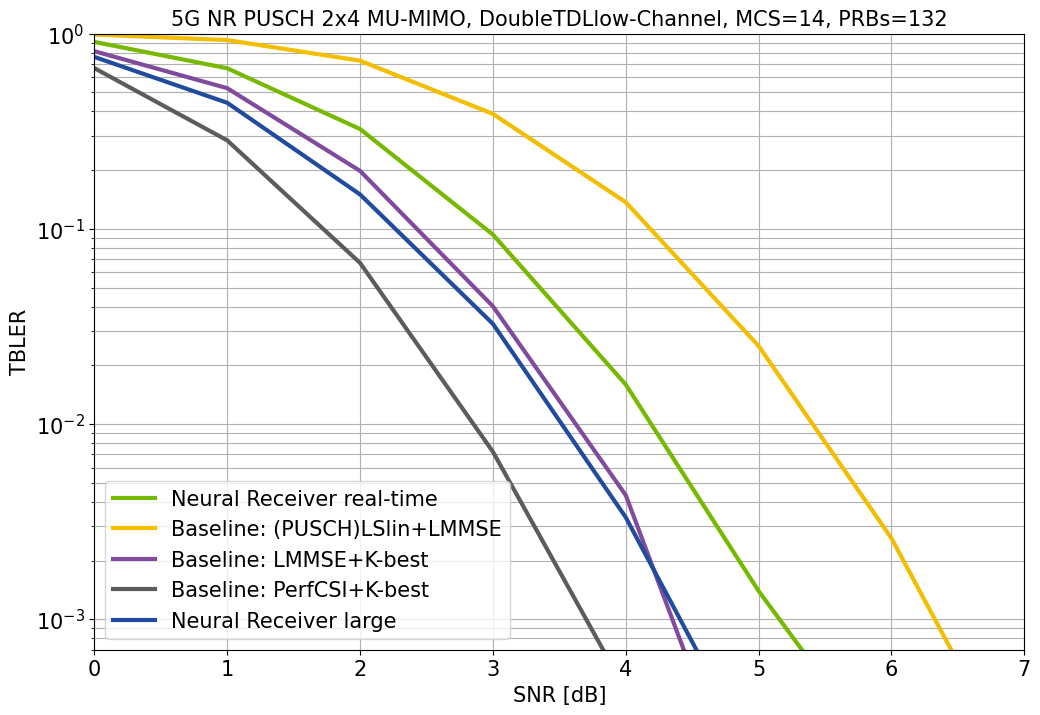

In [12]:
num_tx_eval = 2 # depends on what has been evaluated in evaluate.py before

fig = plot_results(config_name="nrx_rt.cfg", num_tx_eval=num_tx_eval,
                xlim=[0,7], ylim=[7e-4,1],
                labels=["Neural Receiver real-time", "Baseline: (PUSCH)LSlin+LMMSE",
                        "Baseline: LMMSE+K-best", "Baseline: PerfCSI+K-best"])

# and also results for an even larger receiver
fig = plot_results(fig=fig, config_name="nrx_large.cfg",
                   num_tx_eval=num_tx_eval,
                   xlim=[0,7], ylim=[7e-4,1], color_offset=4,
                   labels=["Neural Receiver large"]);

The figure above compares the performance of the NRX with various baselines. All are implemented using the same channel model.
The baselines are:
- LS channel estimation with linear interpolation between pilots and LMMSE-based MIMO detection
- LMMSE-based channel estimation with K-best MIMO detection. The LMMSE channel covariance matrix is generated for the UMi channel and K=64.
- Perfect CSI and K-best detection (K=64)

As can be seen, the NRX slightly outperforms the LMMSE+K-best baseline while benefiting from a lower computational complexity.
Even the low complexity and real-time version operates less than 1 dB away from the aforementioned baseline. 

## Advanced Topics

There are a couple of additional features that have not been discussed yet.

### Real-time Inference

This code repository has support for *real-time* inference via TensorRT.
It can be enabled by running the script `scripts/compile_onnx.py`.
For further details, please see the [run TRT engine Jupyter notebook](real_time_nrx.ipynb).

### Hardware Impairments

The repository supports adding CFO offset during training and evaluation.
This can be controlled by the `cfo_offset_ppm` parameter in the configuration file. During training the CFO is randomized between 
[-cfo_offset_ppm, cfo_offset_ppm] to keep the receiver universal and robust.

Additional impairments could be easily integrated in a similar way.

### Site-specific Training

Following the ideas of [site-specific
training](https://developer.nvidia.com/blog/towards-environment-specific-base-stations-ai-ml-driven-neural-5g-nr-multi-user-mimo-receiver/),
this framework also supports training and evaluation on external datasets. These datasets could
be either measured or simulated, e.g., by using [Sionna's integrated ray
tracer](https://nvlabs.github.io/sionna/api/rt.html).

For this, one needs to set the `channel_type` to `"Dataset"` and provide the corresponding `tfrecord_filename` for training and evaluation.
For further details, see the [site-specific Jupyter notebook](site_specific_neural_receivers.ipynb).

### Support for Variable MCS

This framework supports variable MCS schemes enabled by re-configurable IO initialization and readout layers.
For further details, please see the [variable MCS Jupyter notebook](variable_mcs_nrx.ipynb).

### End-to-end Learning and Pilotless Communications

The framework also supports end-to-end learning and pilotless communications as described in [[2]](#references).
This requires the following changes in the config file:
- `custom_constellation=True`
- `mask_pilots=True` Note that this is not strictly required, but otherwise the NRX will use the remaining DMRS. As there is currently no *non-DMRS* mode in 5G, we typically use the minimal DMRS and mask the remaining pilots. Alternatively, one could implement custom *non-compliant* DMRS schemes to enable pilotless resource grids.

The utility script `plot_gp`, allows visualizing the *goodput* of the system. See [[2]](#references) for further details.

Remark: the e2e setup currently only works for a single DMRS port.

Please see the [End-to-end Learning Notebook](e2e_pilotless_communications.ipynb) for further details.

## References


[1] S. Cammerer, F. Aït Aoudia, J. Hoydis, A. Oeldemann, A. Roessler, T. Mayer and A. Keller, "[A Neural Receiver for 5G NR Multi-user MIMO](https://arxiv.org/pdf/2312.02601)," IEEE Workshops (GC Wkshps), Dec. 2023.

[2] F. Aït Aoudia and J. Hoydis, "[End-to-end learning for OFDM: From neural receivers to pilotless communication](https://arxiv.org/pdf/2009.05261)," IEEE Trans on Wireless Commun, 2021.